## 3.3 Hypothesis Testing

This notebook serves as a repetition of Task 3.2 but with the utilization of different models for each dataset. The main objective is to compare the performance of the models developed in this task with the models from Task 3.2, using hypothesis testing.

In this notebook, we employ Random Forest Classification (RFC) model for the classification task and Random Forest Regression (RFR) model for the regression task. These models are trained on the respective datasets to evaluate their performance and determine their optimality.

In [138]:
import numpy as np
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import ttest_ind, ttest_rel

%load_ext autoreload
%autoreload 2

import bamboo.gwp_pipeline as gwp
import bamboo.star_pipeline as star
from bamboo.processing import read_csv, split_features_and_target, get_feature_and_target_names 
from bamboo.selection import normalize_train_test, filter_features
from bamboo.model import ModelManager, get_classification_prediction_data
from bamboo.analysis import *

SEED = 42

GWP_CSV = 'datasets/gwp_assessment.csv'
STAR_CSV = 'datasets/star_assessment.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Preperation

Repeated steps to initialisze gwp & star datasets to be passed to models just like in task3_2.ipynb

In [86]:
# ------ GWP ------ #
# Load and process from csv
gwp_data = read_csv(GWP_CSV)
gwp_dataset = gwp.gwp_pipeline(gwp_data, seed=SEED)

# Split features and target and filter features
X_gwp, y_gwp = split_features_and_target(gwp_dataset)
X_gwp_names, y_gwp_name = get_feature_and_target_names(gwp_dataset)
X_gwp, X_gwp_names = filter_features(X_gwp, y_gwp, X_gwp_names, corr_coef=0.05, const_coef=0.01)

# Split into training and testing sets
X_gwp_train, X_gwp_test, y_gwp_train, y_gwp_test = train_test_split(X_gwp, y_gwp, test_size=0.2, random_state=SEED)
X_gwp_train, X_gwp_test = normalize_train_test(X_gwp_train, X_gwp_test)

# ------ STAR ------ #
# Load and process Star from csv
star_data = read_csv(STAR_CSV)
star_dataset = star.star_pipeline(star_data, seed=SEED)

# Split features and target and filter features
X_star, y_star = split_features_and_target(star_dataset)
X_star_names, y_star_name = get_feature_and_target_names(star_dataset)
X_star, X_star_names = filter_features(X_star, y_star, X_star_names, corr_coef=0.01, const_coef=0.01)

# Split into training and testing sets
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y_star, test_size=0.2, random_state=SEED)
X_star_train, X_star_test = normalize_train_test(X_star_train, X_star_test)

/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## GWP Model implementation & training
Random Forest Regression (RFR) model.

In [ ]:
# Initialize the parammeters
parameters = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'max_features': [1, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
}

rfr = RandomForestRegressor(random_state = SEED)

# Instantiate the Model class with SVR model and the parameter grid
gwp_model = ModelManager(model=rfr, params=parameters, search_type='GridSearch')
gwp_model.fit(X_gwp_train, y_gwp_train)

# Save the model
gwp_model.save_model('models/gwp/rfr.pkl')
gwp_model.save_results('results/gwp/rfr.pkl')


## Star Model implementation & training
Random Forest Classification (RFC) model.

<div class="warning">
    <strong>Warning:</strong> Running this model with all parameter configurations may take upwards of an hour to complete. You can load in the saved model and result from the local directories if you would like to use the optimal trained model.
</div>

<style>
.warning {
    background-color: #ffeeba;
    border-color: #ffc107;
    color: #856404;
    padding: 1em;
    margin-top: 1em;
    margin-bottom: 1em;
    border: 1px solid transparent;
    border-radius: 0.25rem;
}
</style>

In [ ]:
# Initialize the parammeters
parameters = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'max_features': [1, 'sqrt', 'log2'],
}

rfc = RandomForestClassifier(random_state = SEED)

# Instantiate the Model class with SVR model and the parameter grid
star_model = ModelManager(model=rfc, params=parameters, search_type='HalvingGridSearch')
star_model.fit(X_star_train, y_star_train)

# Save the model
star_model.save_model('models/star/rfc.pkl')
star_model.save_results('results/star/rfc.pkl')

## GWP Model Analysis

Load in the saved gwp model and results.

In [100]:
gwp_model = ModelManager()
gwp_model.load_model('models/gwp/rfr.pkl')
gwp_model.load_results('results/gwp/rfr.pkl')

Show best model results from parameter tuning

In [194]:
best_configuration = gwp_model.get_best_configuration()
print(best_configuration)


{'Best Params': {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}, 'Best Score': 0.48, 'Time Taken': 0.377}


### Average time & score for each parameter tested
Data collected on 900 parameter configurations using HalvingGridSearchCV to find optimal parameter configuration.

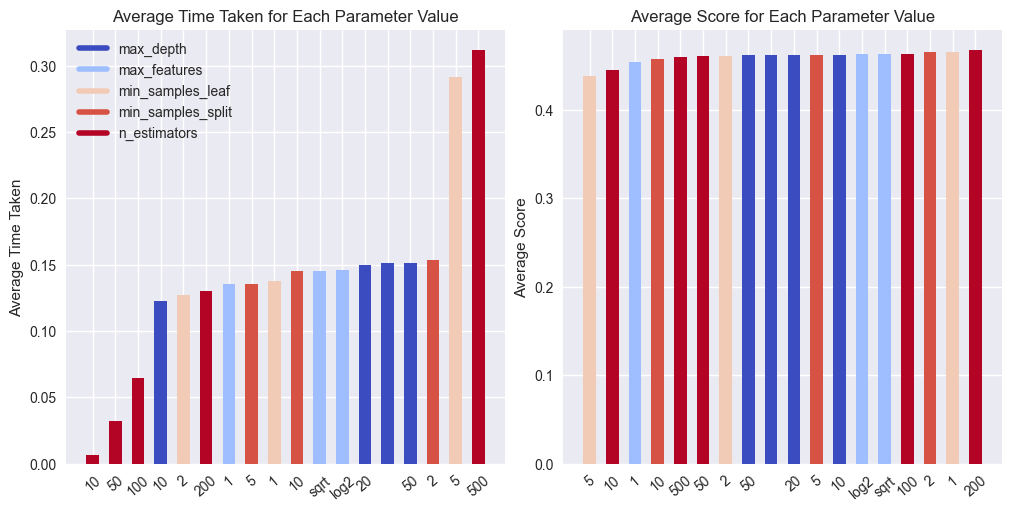

In [103]:
gwp_configurations = gwp_model.get_configurations(sort_by='Score', n_results=250, ascending=False)
plot_bar_avg_metrics(gwp_configurations)

### Predicting on Test set

In [95]:
y_gwp_pred = gwp_model.predict(X_gwp_test)
print_regression_metrics(y_gwp_test, y_gwp_pred)

Score (R-squared): 0.4880824905796163
Mean Absolute Error (MAE): 0.07701922082409807
Root Mean Squared Error (RMSE): 0.11658761740313532


#### Scatter Plot: Predicted vs Actual

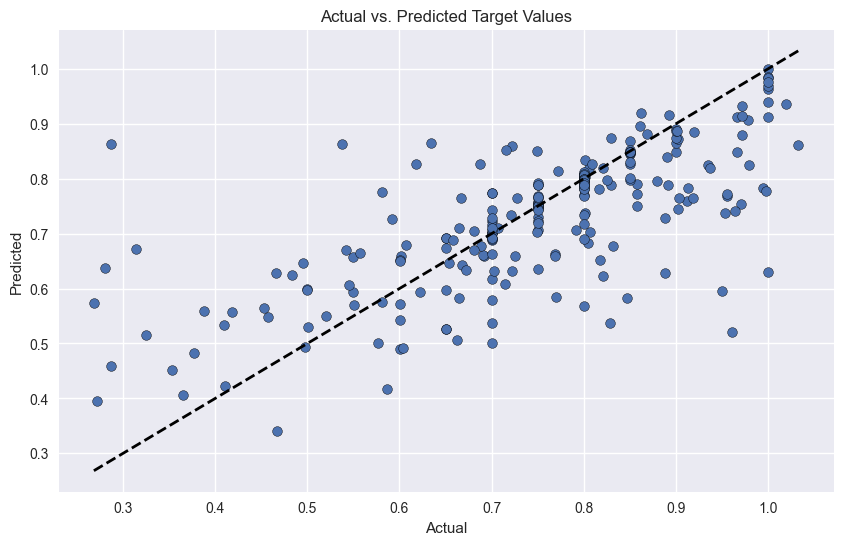

In [96]:
plot_predicted_vs_actual(y_gwp_test, y_gwp_pred)

## Star Model Analysis

Load in the saved star model and results.

In [108]:
star_model = ModelManager()
star_model.load_model('models/star/rfc.pkl')
star_model.load_results('results/star/rfc.pkl')

Show best model results from parameter tuning

In [109]:
star_model.get_best_configuration()

{'Best Params': {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500},
 'Best Score': 0.98,
 'Time Taken': 101.831}

### Precision Recall, ROC, DET Curves

(20000, 3)


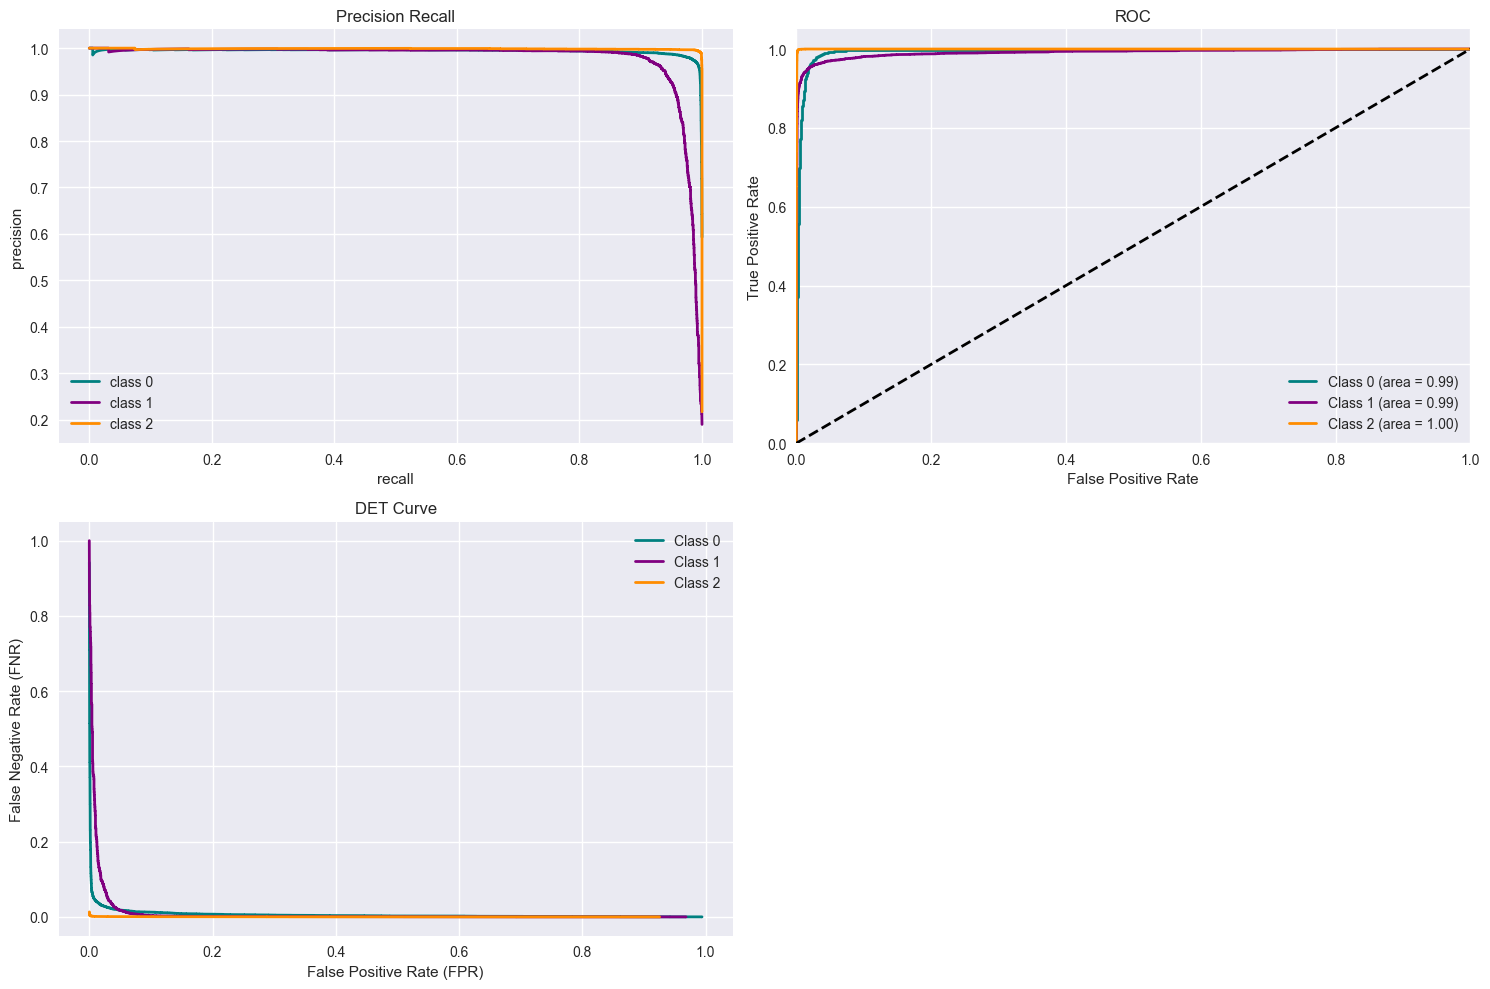

In [192]:
classes = np.unique(y_star_test)
data_per_class = get_classification_prediction_data(star_model.model, X_star_test, y_star_test, classes)

plot_side_by_side(
    lambda: plot_precision_recall_curve(data_per_class, classes), 
    lambda: plot_roc_curve(data_per_class, classes),
    lambda: plot_det_curve(data_per_class, classes),
    titles=['Precision Recall', 'ROC', 'DET Curve'],
    num_cols=2,
    figsize=(15, 10))

### Average time & score for each parameter tested

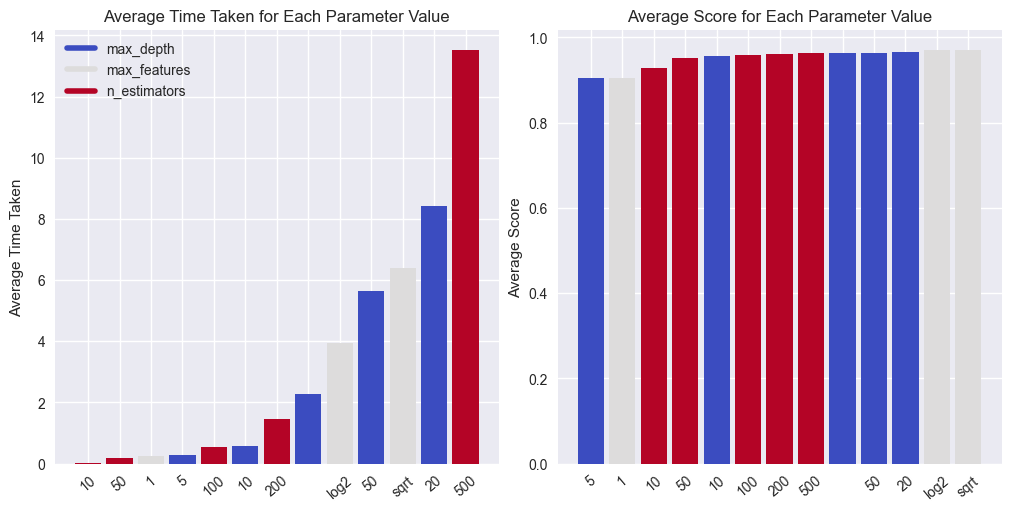

In [111]:
star_configurations = star_model.get_configurations(sort_by='Score', n_results=250, ascending=False)
plot_bar_avg_metrics(star_configurations)

### Predicting on Test set

In [112]:
y_star_pred = star_model.predict(X_star_test)
print("Prediction Score: ", star_model.model.score(X_star_test, y_star_test))

Prediction Score:  0.97585


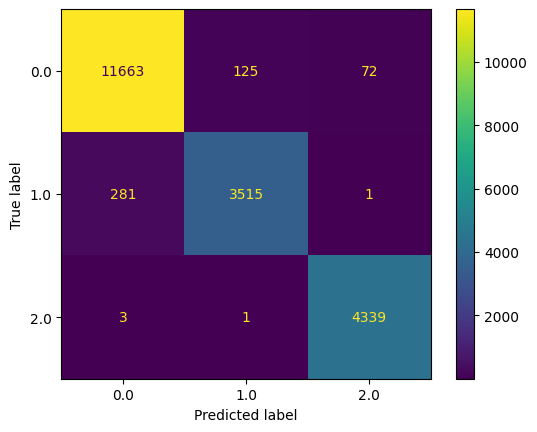

In [114]:
with plt.style.context('default'):
    ConfusionMatrixDisplay.from_predictions(y_star_test, y_star_pred)
    plt.show()

## GWP Hypothesis Testing 

In [115]:
# Load SVR model
gwp_svr = ModelManager()
gwp_svr.load_model('models/gwp/svr.pkl')
gwp_svr.load_results('results/gwp/svr.pkl')

# Load RFR model
gwp_rfr = ModelManager()
gwp_rfr.load_model('models/gwp/rfr.pkl')
gwp_rfr.load_results('results/gwp/rfr.pkl')

**t-test results**: 
- The t-statistic value of -5.06 and the p-value of 0.00068 indicate that there is a significant difference in performance between the SVR and RFR models.
- The SVR model has a mean score of -0.0457, suggesting lower performance, while the RFR model achieves a higher mean score of 0.3145, indicating better performance.

In [137]:
# Perform cross-validation and calculate evaluation metrics for each model
svr_scores = cross_val_score(gwp_svr.model, X_gwp_test, y_gwp_test, cv=10)
rfr_scores = cross_val_score(gwp_rfr.model, X_gwp_test, y_gwp_test, cv=10)

# Perform paired t-test on MSE metrics
t_statistic, p_value = ttest_rel(svr_scores, rfr_scores)

print(f"T-Statistic: {t_statistic} | P-Value: {p_value}")
print(f"SVR Mean: {svr_scores.mean()} | RFR Mean: {rfr_scores.mean()}")


T-Statistic: -5.061365226517552 | P-Value: 0.0006797804995269866
SVR Mean: -0.04567382515594683 | RFR Mean: 0.3144685898306411


## Star Hypothesis Testing 

In [118]:
# Load SVC model
star_svc = ModelManager()
star_svc.load_model('models/star/svc.pkl')
star_svc.load_results('results/star/svc.pkl')

# Load RFC model
star_rfc = ModelManager()
star_rfc.load_model('models/star/rfc.pkl')
star_rfc.load_results('results/star/rfc.pkl')

**t-test results**: 
- t-statistic value of -31.00 and the very small p-value of 1.85e-10 indicate that the SVC model exhibits lower accuracy compared to the RFC model. 
- Mean accuracy for the SVC model is 0.9464, while the RFC model achieves a higher mean accuracy of 0.9743. 

In [135]:
# Perform cross-validation and calculate evaluation metrics for each model
svr_scores = cross_val_score(star_svc.model, X_star_test,  y_star_test, scoring="accuracy", cv=10)
rfr_scores = cross_val_score(star_rfc.model, X_star_test, y_star_test, scoring="accuracy", cv=10)

# Perform paired t-test on MSE metrics
t_statistic, p_value = ttest_rel(svr_scores, rfr_scores)

print(f"T-Statistic: {t_statistic} | P-Value: {p_value}")
print(f"SVC Mean Accuracy: {svr_scores.mean()} | RFC Mean Accuracy: {rfr_scores.mean()}")


T-Statistic: -30.999999999999975 | P-Value: 1.8537582124542086e-10
SVC Mean Accuracy: 0.9464499999999999 | RFC Mean Accuracy: 0.97435


#### Markdown Question: 
**Question** 

What was the hypothesis you rejected for both datasets in this task? How does p-value affect your decision?

**Answer**

The hypothesis that was rejected for both datasets is the null hypothesis. This states that there is no significant difference in performance between the two models. The p-value is what is observed to measure the extend to which the observed data supports or contradicts the null hypothesis. A smaller p-value indicates stronger evidence against the null hypothesis, suggesting that the observed differences in performance between the models are unlikely to occur by chance. 

In both cases, the obtained p-values (1.85e-10 for the star dataset and 0.00068 for the GWP dataset) are extremely small and for off from being close to the value 0.05; a value usually considered to be enough to reject the null hypothesis.  A value closer to 1 than 0 would suggest the opposite, i.e. that the null hypothesis should not be rejected.  Therefore, with such small p-values, we reject the null hypothesis and conclude that there is a significant difference in performance between the compared models.